In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import files
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Set display options
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Import dataset and checking data available

# Step 1: Upload the file
uploaded = files.upload()

# Step 2: Load the file into a pandas DataFrame
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
print(f"Uploaded file: {file_name}")

# Load the file into a DataFrame
mpg = pd.read_excel(file_name)

# Step 3: Display the first few rows of the DataFrame
print("\nData Preview:")
print(mpg.head())

Saving mpg.data (3).xlsx to mpg.data (3).xlsx
Uploaded file: mpg.data (3).xlsx

Data Preview:
    mpg  cylinders  displayments  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model year  origin                   car name  Unnamed: 9  Unnamed: 10  \
0          70       1  chevrolet chevelle malibu         NaN          NaN   
1          70       1          buick skylark 320         NaN          NaN   
2          70       1         plymouth satellite         NaN          NaN   
3          70       1              amc rebel sst         NaN          NaN   
4          70       1                ford torino         NaN          NaN   

   Unnamed: 11 Unnamed

In [3]:
# Preprocessing steps from D02

In [4]:
# Drop unnecessary columns

mpg = mpg.drop(columns = ['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'])

In [5]:
# Correctly rename column "displayments"

mpg = mpg.rename(columns={'displayments': 'displacement'})

In [6]:
# Replace the two-digit year into a four-digit year, replace the model year column and drop the new column

mpg['model_year_full'] = mpg['model year'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)
mpg['model year'] = mpg['model_year_full']
mpg.drop('model_year_full', axis=1, inplace=True)

In [7]:
# Drop null values for the column 'mpg' and replace nulls in the 'horsepower' column with median

mpg = mpg.dropna(subset=["mpg"])
mpg['horsepower'] = mpg['horsepower'].fillna(mpg['horsepower'].median())

pd.isnull(mpg).sum()

,0
mpg,0
cylinders,0
displacement,0
horsepower,0
weight,0
acceleration,0
model year,0
origin,0
car name,0


In [8]:
# Change data type for displacement and horsepower

columns_for_change = ['displacement', 'horsepower']
mpg[columns_for_change] = mpg[columns_for_change].astype(int)

In [9]:
# Split the "car model" column to make two separate columns "brand" and "car name"

mpg[['brand', 'model']] = mpg['car name'].str.split(' ', n=1, expand=True)
mpg['model'] = mpg['model'].str.replace(' ', ' ', regex=False)

In [10]:
# Remove "car name" and "model" columns

mpg.drop('car name', axis=1, inplace=True)
mpg.drop('model', axis=1, inplace=True)

In [11]:
# Correct the mispelled brand names

brand_corrections = {
    "vw": "volkswagen",
    "maxda": "mazda",
    "chevroelt": "chevrolet",
    "chevy": "chevrolet",
    "toyouta": "toyota",
    "mercedes": "mercedes-benz","vokswagen": "volkswagen","capri":"ford","mercury":"ford","triumph":"bmw","plymouth":"chrysler"}
mpg["brand"] = mpg["brand"].replace(brand_corrections)

In [12]:
# Determine the top brands (top 5 by count). One-hot encode the top brands and combine others

top_brands = mpg["brand"].value_counts().nlargest(5).index
mpg_encoded = pd.get_dummies(mpg["brand"].where(mpg["brand"].isin(top_brands), "other"))

In [13]:
# Merge "mpg" and "mpg_endoded" DataFrames and drop "brand" column

mpg = pd.concat([mpg, mpg_encoded], axis=1)
mpg.drop('brand', axis=1, inplace=True)

In [14]:
# New column Efficiency replacing numbers with categories
# (max - min) / 3 -> low (3), medium (2), high (1) fuel efficiency

# Calculate min, max, and range
min_mpg = mpg['mpg'].min()
max_mpg = mpg['mpg'].max()
range_mpg = max_mpg - min_mpg

# Calculate thresholds
thresholds = [min_mpg + range_mpg * i / 3 for i in (1, 2)]

# Define bins and labels
bins = [float('-inf')] + thresholds + [float('inf')]
labels = [3, 2, 1]  # Low (3), Medium (2), High (1)

# Apply classification
mpg['efficiency'] = pd.cut(mpg['mpg'], bins=bins, labels=labels, include_lowest=True)

In [15]:
# Remove "mpg" column

mpg.drop('mpg', axis=1, inplace=True)

mpg.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other,efficiency
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False,3
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True,3
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False,3
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False,3
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False,3


In [16]:
# D03 Model - Evaluate - Predict - Fine Tune
# Logistic Regression

In [17]:
# Logistic Regression Preparation

logistic_df = mpg.copy()

In [18]:
# Split the data into features (X) and target (y)
# features: cylinders, displacement, horsepower, weight, acceleration, model year, origin, brands, performance
# target: efficiency

X_logistic = logistic_df.drop(columns=['efficiency'])
y_logistic = logistic_df['efficiency']

In [19]:
X_logistic.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,amc,chevrolet,chrysler,dodge,ford,other
0,8,307,130,3504,12.0,1970,1,False,True,False,False,False,False
1,8,350,165,3693,11.5,1970,1,False,False,False,False,False,True
2,8,318,150,3436,11.0,1970,1,False,False,True,False,False,False
3,8,304,150,3433,12.0,1970,1,True,False,False,False,False,False
4,8,302,140,3449,10.5,1970,1,False,False,False,False,True,False


In [20]:
y_logistic.head()

,efficiency
0,3
1,3
2,3
3,3
4,3


In [21]:
# Feature scaling

scaler = StandardScaler()
X_logistic_scaled = scaler.fit_transform(X_logistic)

In [22]:
# Split Data in train and test sets

X_logistic_train, X_logistic_test, y_logistic_train, y_logistic_test = train_test_split(X_logistic_scaled, y_logistic, test_size=0.2, random_state=42)

print(f'Training Set Size: {X_logistic_train.shape[0]} samples')
print(f'Test Set Size: {X_logistic_test.shape[0]} samples')

Training Set Size: 318 samples
Test Set Size: 80 samples


In [23]:
# Train the Logistic Regression model

model_logistic = LogisticRegression()

In [24]:
# Fit the model on training data

model_logistic.fit(X_logistic_train, y_logistic_train)

LogisticRegression()

In [25]:
# Predict on training data and test data

pred_train = model_logistic.predict(X_logistic_train)
pred_test = model_logistic.predict(X_logistic_test)

In [27]:
# Evaluate (Accuracy)

train_accuracy = accuracy_score(y_logistic_train, pred_train)
test_accuracy = accuracy_score(y_logistic_test, pred_test)

print(f"Logistic Regression - Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Logistic Regression - Test Accuracy: {test_accuracy * 100:.2f}%")

Logistic Regression - Train Accuracy: 85.85%
Logistic Regression - Test Accuracy: 92.50%


In [30]:
# Comments on Accuracy:

# model generalizes very well, test accuracy higher than the train accuracy, the model is effective on unseen data without overfitting

In [28]:
# Classification Report

print("Classification Report:")
print(classification_report(y_logistic_test, pred_test))

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.75      0.80         8
           2       0.95      0.90      0.92        39
           3       0.92      1.00      0.96        33

    accuracy                           0.93        80
   macro avg       0.91      0.88      0.89        80
weighted avg       0.92      0.93      0.92        80



In [ ]:
# Comments on Classification Report:

# class 1: precision (0.86), model predicts correctly most of the time
# class 2: high precision (0.95) and recall (0.90), well classified with minimal misclassificationhe, model performs very well on this class, it has the most data points
# class 3: perfect recall (1.00), all actual instances were correctly identified, high precision (0.92), very few false positives
# macro avg: f1-score (0.89) all classes perform reasonably well, but class 1 is slightly weaker
# weighted avg: f1-score (0.92) class 2 and 3 have more samples, the model’s strong performance on them boosts the overall score

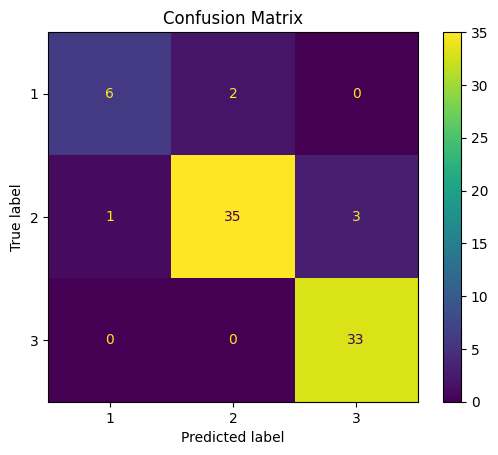

In [29]:
# Confusion Matrix

cm_display = ConfusionMatrixDisplay.from_estimator(model_logistic, X_logistic_test, y_logistic_test, values_format='d')
plt.title("Confusion Matrix")
plt.show()